# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project: Trumps Tweets

**Group Members**: Sarah Chin, Maleah Fekete, Mason Watson, Jasper Fu

In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import statistics
from datetime import datetime

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from gensim import models
import nltk
nltk.download('wordnet')
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /Users/mkw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
trump_tweets = pd.read_csv("data/trump-tweets/trump_tweet.csv")
poll_df = pd.read_csv("data/trump-approval-ratings/approval_topline.csv")

In [3]:
google_word2vec = models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

# Data Inspection and Cleaning 

## Trump Data

In [4]:
trump_tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,It was my great honor to deliver the keynote a...,10-25-2019 19:51:43,5132.0,16938,false,1.187819e+18
1,Twitter for iPhone,Thank you @robertjeffress! https://t.co/o6mk8o...,10-25-2019 17:57:25,6095.0,22287,false,1.187790e+18
2,Twitter for iPhone,RT @GaryCoby: Today @realDonaldTrump is receiv...,10-25-2019 17:35:13,5810.0,0,true,1.187785e+18
3,Twitter for iPhone,Heading to South Carolina! https://t.co/CORtaP...,10-25-2019 17:30:21,8900.0,40776,false,1.187783e+18
4,Twitter for iPhone,RT @gatewaypundit: Breaking Poll: 52% Say Impe...,10-25-2019 16:22:09,7649.0,0,true,1.187766e+18


In [5]:
# Drop this entry because it provides no information under the analyses we are currently performing
trump_tweets = trump_tweets[~trump_tweets.text.isnull()]

# Create new dataframe with null values
trump_tweets = trump_tweets[~trump_tweets.id_str.isnull()]

# Drop indices with a lot of null entries from the main dataframe
trump_tweets = trump_tweets[~trump_tweets.id_str.isnull()]

# The entries with null retweet_count are the same as the entries will
# null favorite_count and null created_at. These are also included in the entries with null id_str.
# We will group all of these into a separate dataframe to deal with null entries

In [6]:
trump_tweets.dtypes

source             object
text               object
created_at         object
retweet_count     float64
favorite_count     object
is_retweet         object
id_str            float64
dtype: object

We notice that favorite_count is an object instead of an number, so we need to convert it before continuing with EDA. We will also change created_at to a DateTime object

In [7]:
trump_tweets["created_at"] = pd.to_datetime(trump_tweets['created_at'], errors='coerce')
trump_tweets["favorite_count"] = pd.to_numeric(trump_tweets["favorite_count"])

In [8]:
trump_tweets.dtypes

source                    object
text                      object
created_at        datetime64[ns]
retweet_count            float64
favorite_count             int64
is_retweet                object
id_str                   float64
dtype: object

Since our project is meant to predict approval ratings we drop tweets from
before Trump became president and have tweets up to LAST_DAY_TWEETS

In [26]:
ANALYSIS_START_DATE = datetime(2017, 1, 23).date()
LAST_DAY_TWEETS = trump_tweets["created_at"].iloc[0]

trump_tweets = trump_tweets[trump_tweets["created_at"] >= ANALYSIS_START_DATE]

/Users/mkw/opt/anaconda3/envs/trumptweetsapproval/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


## Poll Data

In [9]:
poll_df.dtypes

subgroup                object
modeldate               object
approve_estimate       float64
approve_hi             float64
approve_lo             float64
disapprove_estimate    float64
disapprove_hi          float64
disapprove_lo          float64
timestamp               object
dtype: object

We notice `modeldate` and `timestamp` were 'object' type so we converted them to dteday


In [10]:
timestamps = pd.to_datetime(poll_df.timestamp)
dates = pd.to_datetime(poll_df.modeldate)

poll_df.timestamp = timestamps
poll_df.modeldate = dates

# Sort the entries by date
sorted_df = poll_df.sort_values(by = ["modeldate"])
sorted_df.dtypes
sorted_df = sorted_df.reset_index(drop = True)

# EDA

## Trump Tweet Plots

In [ ]:
scaler = MinMaxScaler()
trump_tweets_main[['favorite_count', 'retweet_count']] = scaler.fit_transform(trump_tweets_main[['favorite_count', 'retweet_count']])

trump_tweets_main["fbyr"] = np.log(trump_tweets_main["favorite_count"] / trump_tweets_main["retweet_count"])

In [ ]:
trump_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'true']
trump_not_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'false']

In [ ]:
plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["retweet_count"])
plt.xlabel("date of tweet")
plt.ylabel("retweet count")
plt.title("retweet count over time")
plt.show()

plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["favorite_count"])
plt.xlabel("date of tweet")
plt.ylabel("favorite count")
plt.title("favorite count over time")
plt.show()

plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["fbyr"], )
plt.ylabel("favorite/retweet ratio (log)")
plt.xlabel("date of tweet")
plt.title("favorite/retweet ratio (log) count over time")
plt.show()

## Poll Data

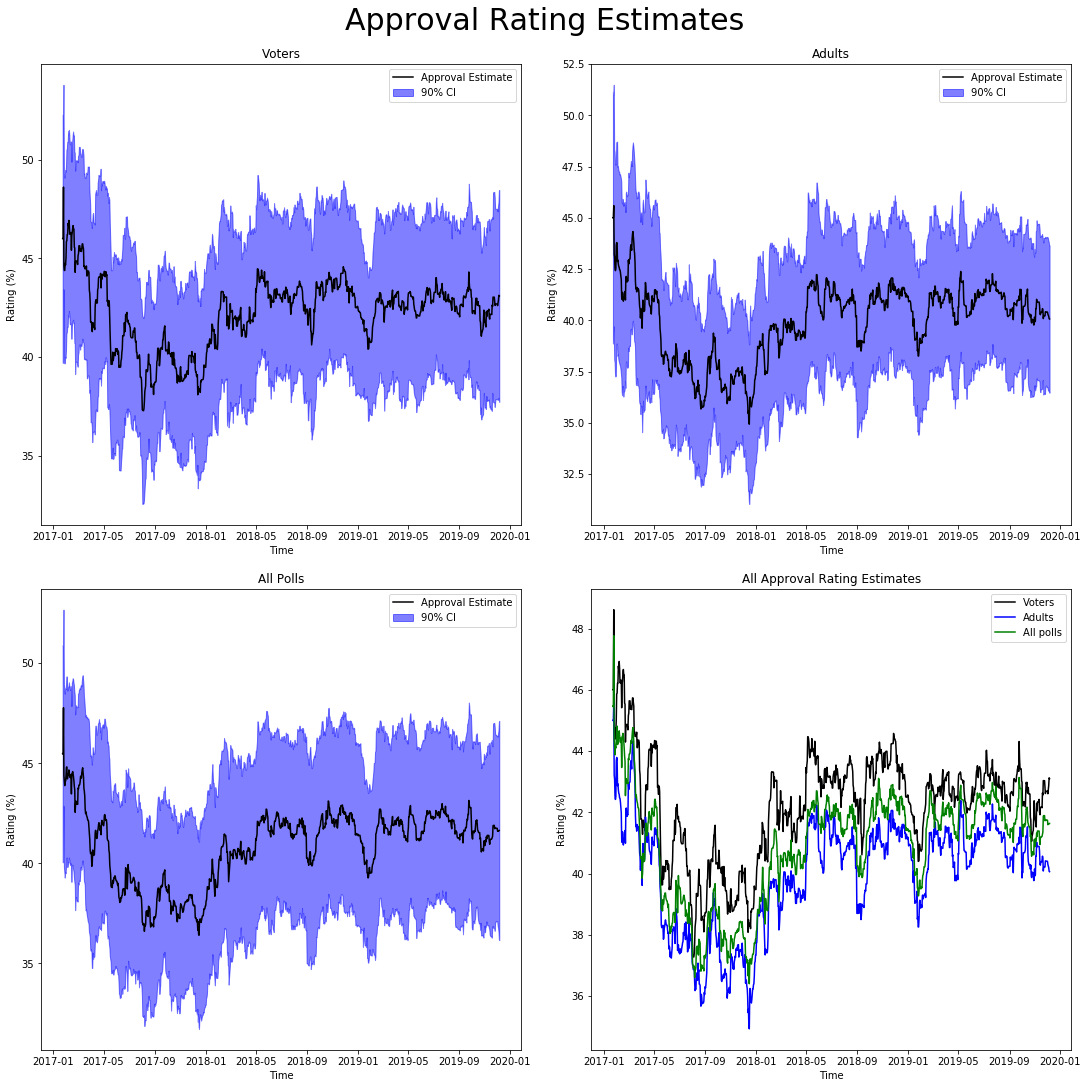

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15), constrained_layout = True)

ax[0][0].plot(sorted_df[sorted_df.subgroup == "Voters"].modeldate,
           sorted_df[sorted_df.subgroup == "Voters"].approve_estimate, color = 'k', label = "Approval Estimate")
ax[0][0].fill_between(sorted_df[sorted_df.subgroup == "Voters"].modeldate,
                 sorted_df[sorted_df.subgroup == "Voters"].approve_lo,
                 sorted_df[sorted_df.subgroup == "Voters"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[0][0].legend()
ax[0][0].set_title("Voters")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("Rating (%)")

ax[0][1].plot(sorted_df[sorted_df.subgroup == "Adults"].modeldate,
           sorted_df[sorted_df.subgroup == "Adults"].approve_estimate, color = 'k', label = 'Approval Estimate')
ax[0][1].fill_between(sorted_df[sorted_df.subgroup == "Adults"].modeldate,
                 sorted_df[sorted_df.subgroup == "Adults"].approve_lo,
                 sorted_df[sorted_df.subgroup == "Adults"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[0][1].legend()
ax[0][1].set_title("Adults")
ax[0][1].set_xlabel("Time")
ax[0][1].set_ylabel("Rating (%)")

ax[1][0].plot(sorted_df[sorted_df.subgroup == "All polls"].modeldate,
           sorted_df[sorted_df.subgroup == "All polls"].approve_estimate, color = 'k', label = "Approval Estimate")
ax[1][0].fill_between(sorted_df[sorted_df.subgroup == "All polls"].modeldate,
                 sorted_df[sorted_df.subgroup == "All polls"].approve_lo,
                 sorted_df[sorted_df.subgroup == "All polls"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[1][0].legend()
ax[1][0].set_title("All Polls")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("Rating (%)")

ax[1][1].plot(sorted_df[sorted_df.subgroup == "Voters"].modeldate,sorted_df[sorted_df.subgroup == "Voters"].approve_estimate, color = 'k', label = "Voters")
ax[1][1].plot(sorted_df[sorted_df.subgroup == "Adults"].modeldate,sorted_df[sorted_df.subgroup == "Adults"].approve_estimate, color = 'b', label = "Adults")
ax[1][1].plot(sorted_df[sorted_df.subgroup == "All polls"].modeldate,sorted_df[sorted_df.subgroup == "All polls"].approve_estimate, color = 'g', label = "All polls")
ax[1][1].legend()
ax[1][1].set_title("All Approval Rating Estimates")
ax[1][1].set_xlabel("Time")
ax[1][1].set_ylabel("Rating (%)")

plt.suptitle("Approval Rating Estimates", fontsize = 30)

plt.show()

Just by looking at the graphs, it doesn't look like the data from just adult population and the data from just the voter population vary much from the data from all polls, but we can also check this by measuring the data similarity.

In [12]:
# Evaluate similarity scores between the data

def similarity(list1,list2):
    x = []
    for i in range(len(list1)):
        x.append(abs(list1[i] - list2[i]))
    return np.mean(x)

similar_adults_voters = similarity(list(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), list(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate))
similar_adults_all = similarity(list(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), list(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))
similar_voters_all = similarity(list(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate), list(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))

print(similar_adults_voters, similar_adults_all, similar_voters_all)
print(2*np.std(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), 
      2*np.std(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate), 
      2*np.std(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))

2.2729759942748093 0.923133264312977 1.3530266612595423
3.5522695473266843 3.4286256037833467 3.5950257015139337


Our similarity scores are all within two standard deviations, so it is sufficient to just choose one set of data - we'll use "All polls" - for our project as it is is a larger population and should grant us more statistical power.

# Feature Engineering 

## Extraction of Usable Features from Tweet Data

### Parsing Tweets

This list of words was constructed by running several rounds of clustering and determining clusters which did not provide useful semantic information for analysis in addition to using an external list of stop words provided by nltk.org

In [14]:
stop_words = ["bring", "iphone", "android", "twitter", "give", "want", "think", "do", "anything", "n't", "really", "get",
              "know", "go", "watch", "good", "great", "&", "not", "can't", "%", "@", "#",
              "rt", "amp", ".", ",", "!", "?", ":", "i", "me", "my", "myself", "we", "our",
              "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he",
              "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom",
              "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been",
              "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
              "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
              "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where",
              "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
              "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
              "just", "don", "should", "now"]

In [15]:
#un-capitalize
trump_tweets['fix_text'] = trump_tweets['text'].apply(lambda x : str.lower(x))

#getting rid of stopwords
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

trump_tweets['fix_text']

# #getting rid of URLs (and handles)
trump_tweets['fix_text'] = trump_tweets['fix_text'].str.replace(r'http\S+', '').astype('str')

# #stemming and lemmatizing
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()

trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'v') for word in x.split()]))

# #tokenize
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(word_tokenize)
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: [word for word in x if word not in (stop_words)])

trump_tweets['fix_text'].head()

### Word2Vec Embeddings

In [16]:
tweet_vectors = np.zeros((trump_tweets.shape[0], 300))
word_vectors = []

for i in range(trump_tweets.shape[0]):
    tokenized_tweet = trump_tweets['fix_text'].iloc[i]
    n = len(tokenized_tweet)
    
    for j in range(n):
        try:
            word_vectors.append(google_word2vec.get_vector(tokenized_tweet[j]))
        except:
            pass

This KMeans loop below is used to generate the categories (the centroids defined by cat_list in the next cell) and cluster centers we use to flag tweets. We comment it out here just because of its computational complexity.

In [17]:
kmeanModel = KMeans(n_clusters=20).fit(word_vectors)

for k in range(20):
    display(google_word2vec.most_similar(positive=[kmeanModel.cluster_centers_[k]], topn=5))

[('nation', 0.8422536253929138),
 ('country', 0.8056609630584717),
 ('state', 0.7014471292495728),
 ('world', 0.6982338428497314),
 ('region', 0.6050415635108948)]

[('bring', 0.6838741898536682),
 ('make', 0.6834613084793091),
 ('get', 0.6613808870315552),
 ('give', 0.6499600410461426),
 ('take', 0.6436672806739807)]

[('sunday', 0.8548504710197449),
 ('monday', 0.8505405187606812),
 ('friday', 0.8468143343925476),
 ('saturday', 0.8432332277297974),
 ('tuesday', 0.8215956091880798)]

[('love', 0.9922901391983032),
 ('loved', 0.6923830509185791),
 ('adore', 0.6849928498268127),
 ('hate', 0.6837970614433289),
 ('loves', 0.6656082272529602)]

[('%_#F########_7v.jsn', 0.7118296027183533),
 ('%_#F########_3v.jsn', 0.6634187698364258),
 ('By_Jonas_Elmerraji', 0.6617088913917542),
 ('UDBKL', 0.6560056209564209),
 ('EAGLE_COLO', 0.6538770198822021)]

[('fight', 0.9786978960037231),
 ('fighting', 0.8049831390380859),
 ('fights', 0.7509102821350098),
 ('battle', 0.6985206007957458),
 ('fought', 0.6481471061706543)]

[('not', 0.7298932075500488),
 ('do', 0.7202686667442322),
 ('anyway', 0.7041991949081421),
 ('probably', 0.6835712194442749),
 ('certainly', 0.6727569103240967)]

[('america', 0.8160041570663452),
 ('ryan', 0.7749332785606384),
 ('usa', 0.7647690773010254),
 ('thompson', 0.7615964412689209),
 ('carl', 0.7605465650558472)]

[('democrat', 0.909200131893158),
 ('republican', 0.8045192956924438),
 ('democrats', 0.7697342038154602),
 ('Democrat', 0.7031162977218628),
 ('liberal_democrat', 0.7008048892021179)]

[('hey', 0.7567526698112488),
 ('Golly_gee', 0.7467779517173767),
 ('Boy_howdy', 0.7392216920852661),
 ('Umm_yeah', 0.7387815713882446),
 ('Laughing.', 0.7354212403297424)]

[('UDBKL', 0.70759516954422),
 ('Alleged_molester', 0.686403214931488),
 ('PSKXF', 0.6835428476333618),
 ('Stab_victim', 0.679111897945404),
 ('stuttered_terribly', 0.6775925159454346)]

[('total', 0.6595807075500488),
 ('first', 0.6031333208084106),
 ('five', 0.6016270518302917),
 ('six', 0.5928008556365967),
 ('four', 0.5818417072296143)]

[('tell', 0.8001242876052856),
 ('know', 0.7903846502304077),
 ('see', 0.7519827485084534),
 ('say', 0.743230938911438),
 ('ask', 0.7181674242019653)]

[('obama', 0.9810978770256042),
 ('clinton', 0.8193141222000122),
 ('mccain', 0.7697098255157471),
 ('hillary', 0.7628995180130005),
 ('george_bush', 0.7440682649612427)]

[('tonight', 0.6657191514968872),
 ('night', 0.6526880264282227),
 ('weekend', 0.6354285478591919),
 ('day', 0.6267039775848389),
 ('Injury_mars', 0.6133421063423157)]

[('dpa_fp', 0.8128902912139893),
 ('dpa_dc', 0.8076013922691345),
 ('kulhadd', 0.8045668601989746),
 ('dpa_rt', 0.8031558990478516),
 ('dpa_ry', 0.8015717267990112)]

[('thank', 0.9999716877937317),
 ('sincerely_thank', 0.8008043766021729),
 ('thanking', 0.786245584487915),
 ('Thank', 0.7777246832847595),
 ('heartfelt_thanks', 0.7647331953048706)]

[('trump', 0.9999999403953552),
 ('trumps', 0.7200154662132263),
 ('trumping', 0.5806604623794556),
 ('supersede', 0.5600546598434448),
 ('trumped', 0.5498014092445374)]

[('INSTANT_VIEW_Reaction', 0.6452966928482056),
 ('By_Jonas_Elmerraji', 0.6241902709007263),
 ('By_Laurelle_Gilbert', 0.6189842224121094),
 ('%_#F########_3v.jsn', 0.617552638053894),
 ('Sophia_Nakano', 0.6103136539459229)]

[('forward', 0.9999990463256836),
 ('foward', 0.7231850624084473),
 ('froward', 0.5256036520004272),
 ('Dominic_Rhodes_plow', 0.5035220384597778),
 ('Timminco_cautions', 0.4807929992675781)]

Based on the general themes of clusters, we construct two lists of tags with varying granularities. One list by looking at the most prominent centroids and dropping those that have no semantic meaning. The second list is constructed in a similar way but trying to further generalize semantic meanings to reduce correlations between tags, ignoring centroids which are similar to already selected centroids. Notably, in our analyses the word Russia does not appear as a common theme which we would have almost certainly naively introduced.

In [20]:
cat_list = ['obama', 'criminal', 'thanks', 'america', 'china', 'money',
            'president', 'democrat', 'trump', 'vote', 'jobs']

general_cat_list = ['democrat', 'criminal', 'trump', 'jobs', 'thanks', 'america']

For every tweet in our cleaned `trump_tweets` dataframe, we construct a taglist to
flag the words in the tweet that are sufficiently close to our centroids attained through the inductive analysis described above. This introduces a new parameter `WORD_SENSITIVITY` which defines how close a word must be to a centroid to be tagged.

In [21]:
WORD_SENSITIVITY = 0.65

tag_list = []
tag_dict = {}
for tweet_num in trump_tweets['fix_text'].index:
    for word in trump_tweets['fix_text'][tweet_num]:
        for cat in range(len(cat_list)):
            try:
                if google_word2vec.similarity(word, cat_list[cat]) >= WORD_SENSITIVITY:
                    tag_list.append(cat_list[cat])
            except:
                pass
    tag_dict.update({tweet_num:tag_list})
    tag_list = []

In [23]:
# add category indicators to each list
for cat in cat_list:
    indicator_arr = []
    
    # TODO: may want to do a sum of how many times instead of binary here
    for tags in tag_dict.values():
        if cat in tags:
            indicator_arr.append(1)
        else:
            indicator_arr.append(0)
            
    trump_tweets[f"tag_{cat}"] = indicator_arr

In [24]:
#Helper functions in order to convert columns in our dataframes


def to_date(df, ind):
    return df["created_at"].loc[ind].date()

#used to convert datetimes into the number of minutes past midnight, so we can find what time of day a tweet was posted
def avg_time(group):
    avg = []
    for tweet_time in group["created_at"]:
        tts = tweet_time.time()
        avg.append(tts.hour*60 + tts.minute)
    m_time = sum(avg)/len(avg)
    var_time = statistics.variance(avg) if len(avg) > 1 else 0
    return {"avg": m_time,"var": var_time}

In [31]:
all_df = pd.DataFrame()

tweets_by_day = trump_tweets.groupby(lambda x: to_date(trump_tweets, x))

all_df["tweet_count"] = tweets_by_day.count()["created_at"]
all_df["rt_avg"] = tweets_by_day.mean()["retweet_count"]
all_df["rt_var"] = tweets_by_day.var()["retweet_count"]
all_df["time_avg"] = tweets_by_day.apply(lambda x: avg_time(x)["avg"])
all_df["time_var"] = tweets_by_day.apply(lambda x: avg_time(x)["var"])

# aggregate tags
for cat in cat_list:
    all_df[f"tag_{cat}_sum"] = tweets_by_day.sum()[f"tag_{cat}"]

# Add previous day's ratings as a feature
poll_df = poll_df[poll_df["subgroup"] == "All polls"]
poll_df["modeldate"] = pd.to_datetime(poll_df["modeldate"], errors='coerce')
poll_df = poll_df[poll_df["modeldate"] <= LAST_DAY_TWEETS]

# Fill in days where trump did not tweet but we have poll data with NaN for now to be fixed later
all_df = all_df.reindex(poll_df["modeldate"], fill_value=0).reset_index()
all_df['is_weekend'] = all_df['modeldate'].apply(lambda x: (x.weekday() - 4) > 0)

#get the polling data and sort it by date
prev_rating_df = poll_df.sort_values(by = ["modeldate"])
prev_rating_df = prev_rating_df.reset_index(drop = True)
prev_day_ratings = [prev_rating_df.approve_estimate[i] for i in range(all_df.shape[0])]
df = all_df[1:-1].sort_values(by = ['modeldate']).reset_index(drop =True)
df.head()

#set y_dataframe to be everything except the first entry
y_df = poll_df.reset_index(drop = True)[1:-1]
y_df = y_df.reset_index(drop=True)
df = df.merge(y_df, left_on="modeldate", right_on="modeldate", how="left")

#drop extraneous columns from polling data
columns_to_drop = ['modeldate', 'approve_hi', 'approve_lo',
                   'disapprove_hi', 'disapprove_lo', 'timestamp', 'subgroup', 'disapprove_estimate']

result_df = df.drop(columns=columns_to_drop)

##get the approval rating a day after a day's tweets to construct the target variable (the delta in approval
##rating the day after a day's tweets)
result_df = result_df.fillna(value={'rt_var': 0})
result_df['next_day_approval'] = np.roll(result_df['approve_estimate'], shift = -1)

##dropping the last row, which will not have a "next" days poll result; dropping a single data point from ~1000 days
## of data should not have a significant impact on our analysis
result_df.drop(result_df.index[[-1]])
result_df['delta'] =  result_df["next_day_approval"] - result_df["approve_estimate"]
result_df = result_df.drop("approve_estimate", 1)
result_df = result_df.drop("next_day_approval", 1)
result_df.head()

,tweet_count,rt_avg,rt_var,time_avg,time_var,tag_obama_sum,tag_criminal_sum,tag_thanks_sum,tag_america_sum,tag_china_sum,tag_money_sum,tag_president_sum,tag_democrat_sum,tag_trump_sum,tag_vote_sum,tag_jobs_sum,is_weekend,delta
999,22,17860.954545,4.790773e+07,593.681818,249389.274892,4,0,0,4,0,0,1,4,3,0,0,True,-0.32763
1000,18,13980.222222,4.861242e+07,314.944444,128918.761438,1,0,0,1,0,0,0,3,2,1,0,False,0.04987
1001,41,12328.609756,4.068521e+07,383.170732,158336.645122,1,0,0,1,0,0,2,4,3,10,0,False,-0.49765
1002,47,12964.255319,3.804637e+07,704.617021,120763.024052,4,0,0,5,0,2,0,12,3,2,0,False,-0.19327
1003,15,14270.333333,4.838450e+07,560.866667,177346.695238,1,0,0,1,0,1,1,1,2,1,0,False,4.87565


In [32]:
result_df.to_csv("data/main_df.csv")

# Prediction Modeling

Looking at the context of our problem and the dataset, we are working in a regression context with a continuous target variable. Moreover, after aggregating tweets per day and restricting our focus to the presidential term, we do not have a very large number of observations. Then, out of the regression models, we will focus on RandomForestRegressor (which is in many ways the most complex tree-based method) and LinearRegression (including with polynomial features and interaction terms) since there would not be enough data to train a neural network. Moreover, these models retain some sense of interpretability which will be important to understand the association between Trump's tweet behavior and his approval ratings.

In [ ]:
y = result_df['delta']
X = result_df.drop(columns=['delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [ ]:
# From the HW3 solutions provided by the TFs, we use this to construct higher-order-features
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=[],
                    target_col='counts', 
                    bad_columns=['casual', 'registered']):
    
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # avoids error if column is already dropped
    for bad_col in bad_columns:        
        if bad_col in train_df.columns:
            train_df = train_df.drop(columns=[bad_col])
        
        if bad_col in val_df.columns:
            val_df = val_df.drop(columns=[bad_col])
        
    nonB_train = train_df[train_df.columns.difference(nb)]
    nonB_val = val_df[val_df.columns.difference(nb)]
    
    train_std, val_std = standardize(train_df, val_df, nonB_train.columns)
            
    aug_train = augment(train_std, columns_forpoly, degree)
    aug_val = augment(val_std, columns_forpoly, degree)
    
    inter_train = add_interactions(aug_train, train_df)
    inter_val = add_interactions(aug_val, val_df)
            
    X_train = inter_train.drop(columns=[target_col])
    y_train = train_df[target_col]
        
    X_val = inter_val.drop(columns=[target_col])
    y_val = val_df[target_col]
    
    return X_train, y_train, X_val, y_val

In [ ]:
linear_model = LinearRegression().fit(X_train, y_train)

In [ ]:
linear_model.score(X_test, y_test)

## RandomForestRegressor

In [ ]:
max_depth = [1, 5, 10, 15, 20, 25, 30]

rf_model = RandomForestRegressor().fit(X_train, y_train)
rf_model.score(X_test)

# Testing for Coefficient Significance

## Permutation Test

In [ ]:
coeffs = []
cols = X_train.columns
for i in range(1000):
    y_perm = np.random.permutation(y_train)
    model = LinearRegression()
    model.fit(X_train, y_perm)
    coeffs.append(model.coef_)

coefficients_perm = pd.DataFrame(np.vstack(coeffs), columns = cols)

In [ ]:
significant_perm = pd.DataFrame({'CI':['lower', 'upper', 'significant?']})

for col in cols:
    m = np.mean(coefficients_perm[col])
    std = np.std(coefficients_perm[col])
    low = m-(std*1.96)
    up = m+(std*1.96)
    if (low < 0 and up <0) or (low >0 and up >0):
        sig = 'Yes'
    if low <0 and up >0:
        sig = 'No'
    significant_perm[col] = [low, up, sig]

significant_perm.head()

In [ ]:
significance = [significant[col][2] for col in cols]
sig_idx = []
for i in range(len(cols)):
    if significance[i] == 'Yes':
        sig_idx.append(i)
significant_features = cols[sig_idx]